In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt

paper : https://arxiv.org/abs/1706.03762

http://nlp.seas.harvard.edu/2018/04/03/attention.html

maps input sequences to a sequence of continuous representations $x=(x_1 \cdots, x_n) \rightarrow z=(z_1, \cdots, y_n)$, given $z$ generates an output sequence $y=(y_1, \cdots, y_n)$

## 3.2.1 Scaled Dot-Product Attention

In [2]:
class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention"""
    def __init__(self, d_k, return_attn=True):
        super(ScaledDotProductAttention, self).__init__()
        self.return_attn = return_attn
        self.d_k = d_k
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, q, k, v, mask=None):
        """
        Inputs:
        * q: (B, T_q, d_q), d_q = d_k
        * k: (B, T_k, d_k)
        * v: (B, T_v, d_v), T_k = T_v
        -------------------------------
        Outputs:
        * output: (B, T_q, d_v)
        * probs: (B, T_q, T_k)
        """
        assert q.size(2) == k.size(2), "d_q = d_k"
        assert k.size(1) == v.size(1), "T_k = T_v"
        attn = torch.bmm(q, k.transpose(1, 2))  # (B, T_q, d_k) * (B, T_k, d_k) -> (B, T_q, T_k)
        attn = attn / np.sqrt(self.d_k)
        # why doing this? 
        # for the large values of d_k, the dot products grow large in magnitude, 
        # pushing the softmax function into regions where it has extremely small gradients
        # to counteract this effect, scaled the dot products by 1/sqrt(d_k)
        # to illustrate why the dot products get large,
        # check the function 'check_dotproduct_dist'
        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)
        
        attn = self.softmax(attn)  # (B, T_q, T_k) --> (B, T_q, T_k)
        output = torch.bmm(attn, v)  # (B, T_q, T_k) * (B, T_v, d_v) --> (B, T_q, d_v), make sure that T_k == T_v
        if self.return_attn:
            return output, attn
        return output

In [3]:
# ex) translation: 
# q - previous decoder
# k, v - encoder output
# mask should be (B, T_q, T_k), will talk about it later
batch = 1
T_q = 3
T_k, T_v = (4, 4)
d_k = 10
d_v = 12
mask = torch.ByteTensor([[[0, 1, 1, 1],
                          [0, 0, 1, 1],
                          [0, 0, 1, 1]]])
q, k, v = torch.randn((batch, T_q, d_k)), torch.randn((batch, T_k, d_k)), torch.randn((batch, T_v, d_v))
attention = ScaledDotProductAttention(d_k)

In [4]:
output, attn = attention(q, k, v, mask=mask)
output.size(), attn.size()

(torch.Size([1, 3, 12]), torch.Size([1, 3, 4]))

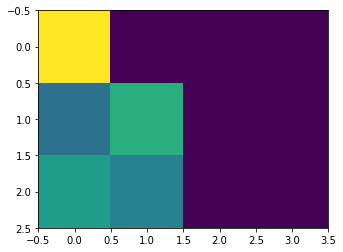

In [5]:
plt.imshow(attn.squeeze(0).numpy())
plt.show()

In [6]:
def check_dotproduct_dist(d_k, sampling_size=1, seq_len=1, threshold=1e-10):
    """
    to check "https://arxiv.org/abs/1706.03762" Paper page 4, annotation 4
    -------------------------------
    To illustrate why the dot products get large, 
    assume that the components of q and k are independent random variables 
    with mean 0 and variance 1.
    Then their dot product has mean 0 and variance d_k
    """
    def cal_grad(attn):
        y = torch.softmax(attn, dim=2)
        return y * (1-y)
    
    q = nn.init.normal_(torch.rand((sampling_size, seq_len, d_k)), mean=0, std=1)
    k = nn.init.normal_(torch.rand((sampling_size, seq_len, d_k)), mean=0, std=1)
    attn = torch.bmm(q, k.transpose(1, 2))
    print('size of vector d_k is {}, sampling result, dot product distribution has \n - mean: {:.4f}, \n - var: {:.4f}'.\
          format(d_k, attn.mean().item(), attn.var().item()))
    grad = cal_grad(attn)
    print( "count of gradients that smaller than threshod({}) is {}, {:.4f}%".format(
        threshold, grad.le(threshold).sum(), grad.le(threshold).sum().item()/grad.view(-1).size(0)*100 ) )
    attn2 = attn / torch.sqrt(torch.as_tensor(d_k).float())
    grad2 = cal_grad(attn2)
    print( "after divide by sqrt(d_k), count of gradients that smaller than threshod({}) is {}, {:.4f}% \n".format(
        threshold, grad2.le(threshold).sum(), grad2.le(threshold).sum().item()/grad2.view(-1).size(0)*100 ) )

In [7]:
print("*** notice that the gradient of softmax is y(1-y) ***")
for d_k in [10, 100, 1000]:
    check_dotproduct_dist(d_k, sampling_size=100000, seq_len=5, threshold=1e-10)

*** notice that the gradient of softmax is y(1-y) ***
size of vector d_k is 10, sampling result, dot product distribution has 
 - mean: 0.0003, 
 - var: 10.0183
count of gradients that smaller than threshod(1e-10) is 199, 0.0080%
after divide by sqrt(d_k), count of gradients that smaller than threshod(1e-10) is 0, 0.0000% 

size of vector d_k is 100, sampling result, dot product distribution has 
 - mean: -0.0067, 
 - var: 100.0631
count of gradients that smaller than threshod(1e-10) is 402257, 16.0903%
after divide by sqrt(d_k), count of gradients that smaller than threshod(1e-10) is 0, 0.0000% 

size of vector d_k is 1000, sampling result, dot product distribution has 
 - mean: -0.0332, 
 - var: 1000.6940
count of gradients that smaller than threshod(1e-10) is 1738234, 69.5294%
after divide by sqrt(d_k), count of gradients that smaller than threshod(1e-10) is 0, 0.0000% 



## 3.2.2 Multi-Head Attention

In [6]:
class XavierLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(XavierLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        nn.init.xavier_normal_(self.linear.weight)

    def forward(self, inputs):
        return self.linear(inputs)

In [7]:
class MultiHeadAttention(nn.Module):
    """Multi-head Attention"""
    def __init__(self, n_head, d_model, d_k, d_v, drop_rate=0.1, return_attn=True):
        """
        paper setting: n_head = 8, d_k = d_v = d_model / n_head = 64
        Multi-head attention allows the model to jointly attend to information from 
        different representation subspaces at different positions.
        with a single attention head, averaging inhibits this.
        """
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.return_attn = return_attn
        self.linear_q = XavierLinear(d_model, n_head*d_k)
        self.linear_k = XavierLinear(d_model, n_head*d_k)
        self.linear_v = XavierLinear(d_model, n_head*d_v)
        self.linear_o = XavierLinear(n_head*d_v, d_model)
        self.attention = ScaledDotProductAttention(d_k, return_attn=return_attn)
        self.drop_out = nn.Dropout(drop_rate)
        
    def forward(self, q, k, v, mask=None):
        """
        Inputs:
        * q: (B, T_q, d_model)
        * k: (B, T_k, d_model)
        * v: (B, T_v, d_model)
        * mask: (B, T_q, T_k)
        ---------------------
        Outputs:
        * output: (B, T_q, d_model)
        * attn: (n_head * B, T_q, T_k)
        """
        n_head, d_model, d_k, d_v = self.n_head, self.d_model, self.d_k, self.d_v
        B, T_q, _ = q.size()
        B, T_k, _ = k.size()
        B, T_v, _ = v.size()
        # through linear layer: 
        # lin_qs : (B, T_q, d_model) --> (B, T_q, n_head * d_k) --> (n_head * B, T_q, d_k)
        # lin_ks : (B, T_k, d_model) --> (B, T_k, n_head * d_k) --> (n_head * B, T_k, d_k) 
        # lin_vs : (B, T_v, d_model) --> (B, T_v, n_head * d_v) --> (n_head * B, T_v, d_v)
        lin_qs = self.linear_q(q).view(B, T_q, n_head, d_k)  
        lin_ks = self.linear_k(k).view(B, T_k, n_head, d_k)  
        lin_vs = self.linear_v(v).view(B, T_v, n_head, d_v)  
        lin_qs = lin_qs.permute(2, 0, 1, 3).contiguous().view(-1, T_q, d_k)
        lin_ks = lin_ks.permute(2, 0, 1, 3).contiguous().view(-1, T_k, d_k)
        lin_vs = lin_vs.permute(2, 0, 1, 3).contiguous().view(-1, T_v, d_v)
        
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # attention: Scaled Dot-Product Attention
        ## heads: (n_head * B, T_q, d_v)
        ## attn: (n_head * B, T_q, T_k)
        if self.return_attn:
            heads, attn = self.attention(q=lin_qs, k=lin_ks, v=lin_vs, mask=mask)
        else:
            heads = self.attention(q=lin_qs, k=lin_ks, v=lin_vs, mask=mask)
        # concat
        # (n_head * B, T_q, d_v) --> (B, T_q, n_head * d_v)
        heads_cat = torch.cat(list(heads.chunk(n_head, dim=0)), dim=-1)  
        output = self.linear_o(heads_cat)  # (B, T_q, n_head * d_v) --> (B, T_q, d_model)
        output = self.drop_out(output)
        if self.return_attn:
            return output, attn
        return output

In [16]:
batch = 1
T_q = 2
T_k, T_v = (5, 5)
n_head = 8
d_model = 3*n_head
d_k = 5
d_v = 5
mask = torch.ByteTensor([[[0, 1, 1, 1, 1],
                          [0, 0, 1, 1, 1]]])
q, k, v = torch.randn((batch, T_q, d_model)), torch.randn((batch, T_k, d_model)), torch.randn((batch, T_v, d_model))
q.size(), k.size(), v.size()

(torch.Size([1, 2, 24]), torch.Size([1, 5, 24]), torch.Size([1, 5, 24]))

In [17]:
multiheadattention = MultiHeadAttention(n_head, d_model, d_k, d_v)
o, attn = multiheadattention(q, k, v, mask=mask)
o.size(), attn.size()

(torch.Size([1, 2, 24]), torch.Size([8, 2, 5]))

## 3.2.3 Application

### Encoder-Decoder attention

* queries: the previous decoder layer
* keys & values: output of the encoder

### Encoder + self-attention

* queries, keys, values come form the output of the previous layer in the encoder

### Decoder + self-attention

* need to prevent leftward information flow in the decoder to preserve the auto-regressive property. 
* implement by masking out (-inf)

## 3.3 Position-wise Feed-Forward Networks

$$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$$
$$\begin{aligned} W_1 &\in \Bbb{R}^{d_{model} \times d_f} \\ 
b_1 &\in \Bbb{R}^{d_f} \\
W_2 &\in \Bbb{R}^{d_f \times d_{model}} \\ 
b_2 &\in \Bbb{R}^{d_{model}} \\
\end{aligned}$$

same as $FFN = Linear(ReLU(Linear(x)) = Conv1d(ReLU(Conv1d))$

In [12]:
class PositionWiseFFN(nn.Module):
    """Position-wise Feed-Forward Networks"""
    def __init__(self, d_model, d_f, drop_rate=0.1, use_conv=False):
        super(PositionWiseFFN, self).__init__()
        self.use_conv = use_conv
        if use_conv:
            self.fc = nn.Sequential(
                nn.Conv1d(d_model, d_f, kernel_size=1),
                nn.ReLU(),
                nn.Conv1d(d_f, d_model, kernel_size=1)
            )
        else:
            self.fc = nn.Sequential(
                nn.Linear(d_model, d_f),
                nn.ReLU(),
                nn.Linear(d_f, d_model)
            )
        self.drop_out = nn.Dropout(drop_rate)
    
    def forward(self, x):
        """
        Inputs:
        x: (B, T, d_model)
        -----------------------
        Ouputs:
        output: (B, T, d_model)
        """
        if self.use_conv:
            x = x.transpose(1, 2)  # (B, T, d_model) --> (B, d_model, T), reshape like (batch, channel, dim)
            output = self.fc(x).transpose(1, 2)  # (B, d_model, T) --> (B, T, d_model)
        else:
            output = self.fc(x)
            
        output = self.drop_out(output)
        return output

In [13]:
d_f = d_model*4
PWFFN = PositionWiseFFN(d_model, d_f, use_conv=False)
PWFFN(q).size()

torch.Size([1, 2, 256])

In [14]:
PWFFN = PositionWiseFFN(d_model, d_f, use_conv=True)
PWFFN(q).size()

torch.Size([1, 2, 256])

## 3.5 Positional Encoding & Embeddings

$$\begin{aligned} PE_{(pos, 2i)} &= sin(pos/10000^{2i / d_{model}}) \\
PE_{(pos, 2i+1)} &= cos(pos/10000^{2i / d_{model}}) \\
\end{aligned}$$

In [15]:
class PositionalEncoding(nn.Module):
    """Positional Encoding"""
    def __init__(self, n_pos, d_model, pad_idx=0):
        """
        n_pos = max sequence length + 1
        """
        super(PositionalEncoding, self).__init__()
        self.n_pos = n_pos
        self.d_model = d_model
        self.pe_table = np.array(self.get_pe_table())
        self.pe_table[:, 0::2] = np.sin(self.pe_table[:, 0::2])
        self.pe_table[:, 1::2] = np.cos(self.pe_table[:, 1::2])
        self.pe_table[pad_idx, :] = 0  # embed all pad to 0
        self.pe = nn.Embedding.from_pretrained(torch.FloatTensor(self.pe_table), freeze=True)
        
    def cal_angle(self, pos, hid_idx):
        return pos / (10000 ** ((2*(hid_idx // 2) / self.d_model)) )
    
    def get_pe_table(self):
        return [[self.cal_angle(pos, i) for i in range(self.d_model)] for pos in range(self.n_pos)]         
        
    def forward(self, inputs):
        return self.pe(inputs)

In [16]:
class Embedding(nn.Module):
    def __init__(self, vocab_len, d_model, pad_idx=1):
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_len, d_model, padding_idx=pad_idx)
        
    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)

In [17]:
n_pos = 3
vocab_len = 10
pos_layer = PositionalEncoding(n_pos+1, d_model)  # n_pos + 1 for pad idx
embed_layer = Embedding(vocab_len, d_model, pad_idx=0)

In [18]:
x = torch.LongTensor(np.array([[6, 5, 3], [1, 3, 0], [5, 3, 6], [3, 6, 2]]))
po_x = torch.LongTensor(np.array([[1, 2, 3], [1, 2, 0], [1, 2, 3], [1, 2, 3]]))
embed_layer(x).size(), pos_layer(po_x).size()

(torch.Size([4, 3, 256]), torch.Size([4, 3, 256]))

In [19]:
inputs = embed_layer(x) + pos_layer(po_x)
inputs.size()

torch.Size([4, 3, 256])

In [20]:
target_n_pos = 4  # equal to max_seq_len
t = torch.LongTensor(np.array([[1, 0, 0, 0], [5, 7, 9, 2], [3, 7, 0, 0], [2, 9, 4, 0]]))
po_t = torch.LongTensor(np.array([[1, 0, 0, 0], [1, 2, 3, 4], [1, 2, 0, 0], [1, 2, 3, 0]]))
pos_layer = PositionalEncoding(target_n_pos+1, d_model)  # n_pos + 1 for pad idx
embed_layer = Embedding(vocab_len, d_model)
embed_layer(t).size(), pos_layer(po_t).size()

(torch.Size([4, 4, 256]), torch.Size([4, 4, 256]))

In [21]:
target_inputs = embed_layer(t) + pos_layer(po_t)
target_inputs.size()

torch.Size([4, 4, 256])

In [22]:
def get_padding_mask(q, k=None, pad_idx=1, mode='attn'):
    """
    mode: attn
    > mask out for pad in attention with queries & keys sequences
    > return shape: (B, T_q, T_k)
    mode: nonpad
    > mask out pad rows in attention
    > return shape: (B, T_q, T_k)
    mode: subseq
    > mask out next tokens to preserve 'auto-regressive property'
    > return shape: (B, T_q, T_q)
    """
    B, q_len = q.size()
    if mode == 'attn':
        assert k is not None, "must have key sequences"
        padding_mask = k.eq(pad_idx)
        padding_mask = padding_mask.unsqueeze(1).expand(B, q_len, -1)
        return padding_mask
    elif mode == 'nonpad':
        # to mask out pad rows
        assert k is None, "don't need key sequences"
        return q.ne(pad_idx).type(torch.float).unsqueeze(-1)
    elif mode =='subseq':
        assert k is None, "don't need key sequences"
        subseq_mask = torch.triu(torch.ones((q_len, q_len), device=q.device, dtype=torch.uint8), 
                                 diagonal=1)
        subseq_mask = subseq_mask.unsqueeze(0).expand(B, -1, -1)
        return subseq_mask

In [23]:
attn_mask = get_padding_mask(q=t, k=t, pad_idx=0, mode='attn')
subseq_mask = get_padding_mask(q=t, mode='subseq')
self_attn_mask = (attn_mask + subseq_mask).gt(0)

In [24]:
self_attn_mask

tensor([[[0, 1, 1, 1],
         [0, 1, 1, 1],
         [0, 1, 1, 1],
         [0, 1, 1, 1]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 1, 1]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]]], dtype=torch.uint8)

In [25]:
non_pad_mask = get_padding_mask(q=t, pad_idx=0, mode='nonpad')
non_pad_mask

tensor([[[1.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [0.]]])

In [26]:
multiheadattention = MultiHeadAttention(n_head, d_model, d_k, d_v)
o, attn = multiheadattention(q=target_inputs, k=target_inputs, v=target_inputs, mask=attn_mask)

In [27]:
o *= non_pad_mask

In [28]:
o

tensor([[[ -0.4242,  -0.3655,   0.3953,  ...,  -0.1497,   0.4583,  -0.0049],
         [ -0.0000,  -0.0000,   0.0000,  ...,  -0.0000,   0.0000,  -0.0000],
         [ -0.0000,  -0.0000,   0.0000,  ...,  -0.0000,   0.0000,  -0.0000],
         [ -0.0000,  -0.0000,   0.0000,  ...,  -0.0000,   0.0000,  -0.0000]],

        [[  2.8123,   0.0000,  -0.0539,  ..., -11.1668,  -4.8402,  23.7759],
         [ 15.8007,   8.3555, -21.1437,  ...,  11.6008,  16.7544,  19.9623],
         [  7.0687,  -0.0000,   9.5903,  ...,  13.4302,  11.8907,  -9.4380],
         [-13.1387,  11.2663,  11.0090,  ..., -35.1497,  -0.0000,  -4.5492]],

        [[-44.0997,  13.5027,  11.6549,  ...,   8.9507,  10.0594,  11.9547],
         [-11.5073,   7.3753,  -8.2744,  ...,  12.8736,   7.3027,  16.2490],
         [ -0.0000,   0.0000,  -0.0000,  ...,   0.0000,   0.0000,  -0.0000],
         [ -0.0000,   0.0000,  -0.0000,  ...,   0.0000,   0.0000,  -0.0000]],

        [[ -7.1606,   0.0000,  20.6702,  ...,   1.6610, -14.5098,  -8.

## Layers

In [29]:
# Encode Layer
class Encode_Layer(nn.Module):
    """encode layer"""
    def __init__(self, n_head, d_model, d_k, d_v, d_f, drop_rate=0.1, use_conv=False, return_attn=True):
        super(Encode_Layer, self).__init__()
        self.return_attn = return_attn
        self.n_head = n_head
        self.selfattn = MultiHeadAttention(n_head, d_model, d_k, d_v, drop_rate=drop_rate, return_attn=return_attn)
        self.pwffn = PositionWiseFFN(d_model, d_f, drop_rate=drop_rate, use_conv=use_conv)
        self.norm_selfattn = nn.LayerNorm(d_model)
        self.norm_pwffn = nn.LayerNorm(d_model)
        
    def forward(self, enc_input, enc_mask=None, non_pad_mask=None):
        """
        Inputs:
        * enc_input: (B, T, d_model)
        * enc_mask: (B, T, T)
        * non_pad_mask: (B, T, 1)
        -------------------------------------
        Outputs:
        * enc_output: (B, T, d_model)
        * enc_attn: (n_head * B, T, T)
        """
        # Layer: Multi-Head Attention + Add & Norm
        # encode self-attention
        if self.return_attn:
            enc_output, enc_attn = self.selfattn(enc_input, enc_input, enc_input, mask=enc_mask)
        else:
            enc_output = self.selfattn(enc_input, enc_input, enc_input, mask=enc_mask)
        enc_output = self.norm_selfattn(enc_input + enc_output)
        enc_output *= non_pad_mask
        
        # Layer: PositionWiseFFN + Add & Norm
        pw_output = self.pwffn(enc_output)
        enc_output = self.norm_pwffn(enc_output + pw_output)
        enc_output *= non_pad_mask
        if self.return_attn:
            # attns cat([B, T, T] * n_heads)
            enc_attn = torch.cat([attn*non_pad_mask \
                                  for attn in enc_attn.chunk(self.n_head, dim=0)], dim=0)
            return enc_output, enc_attn
        return enc_output

In [30]:
# Decode Layer
class Decode_Layer(nn.Module):
    """decode layer"""
    def __init__(self, n_head, d_model, d_k, d_v, d_f, drop_rate=0.1, use_conv=False, return_attn=True):
        super(Decode_Layer, self).__init__()
        self.return_attn = return_attn
        self.n_head = n_head
        self.selfattn_masked = MultiHeadAttention(n_head, d_model, d_k, d_v, drop_rate=drop_rate, 
                                                  return_attn=return_attn)
        self.dec_enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, drop_rate=drop_rate, 
                                               return_attn=return_attn)
        self.pwffn = PositionWiseFFN(d_model, d_f, drop_rate=drop_rate, use_conv=use_conv)
        self.norm_selfattn_masked = nn.LayerNorm(d_model)
        self.norm_dec_enc_attn = nn.LayerNorm(d_model)
        self.norm_pwffn = nn.LayerNorm(d_model)
    
    def forward(self, dec_input, enc_output, dec_self_mask=None, 
                dec_enc_mask=None, non_pad_mask=None):
        """
        Inputs:
        * dec_input: (B, T_q, d_model)
        * enc_input: (B, T, d_model)
        * dec_self_mask: (B, T_q, T_q)
        * dec_enc_mask: (B, T_q, T)
        * non_pad_mask: (B, T_q, 1)
        -------------------------------------
        Outputs:
        * dec_output: (B, T_q, d_model)
        * dec_self_attn: (n_head * B, T_q, T_q)
        * dec_enc_attn: (n_head * B, T_q, T)
        """
        # Layer: Multi-Head Attention + Add & Norm
        # decode self-attention
        if self.return_attn:
            dec_self_output, dec_self_attn = self.selfattn_masked(dec_input, dec_input, dec_input, 
                                                                  mask=dec_self_mask)
        else:
            dec_self_output = self.selfattn_masked(dec_input, dec_input, dec_input, 
                                                   mask=dec_self_mask)
        dec_self_output = self.norm_selfattn_masked(dec_input + dec_self_output)
        dec_self_output *= non_pad_mask
        
        # Layer: Multi-Head Attention + Add & Norm
        # decode output(queries) + encode output(keys, values)
        if self.return_attn:
            dec_output, dec_enc_attn = self.dec_enc_attn(dec_self_output, enc_output, enc_output, 
                                                         mask=dec_enc_mask)
        else:
             dec_output = self.dec_enc_attn(dec_self_output, enc_output, enc_output, mask=dec_enc_mask)
        dec_output = self.norm_dec_enc_attn(dec_self_output + dec_output)
        dec_output *= non_pad_mask
        
        # Layer: PositionWiseFFN + Add & Norm
        pw_output = self.pwffn(dec_output)
        dec_output = self.norm_pwffn(dec_output + pw_output)
        dec_output *= non_pad_mask
        if self.return_attn:
            dec_self_attn = torch.cat([attn*non_pad_mask \
                                       for attn in dec_self_attn.chunk(self.n_head, dim=0)], dim=0)
            dec_enc_attn = torch.cat([attn*non_pad_mask \
                                      for attn in dec_enc_attn.chunk(self.n_head, dim=0)], dim=0)
            return dec_output, dec_self_attn, dec_enc_attn
        return dec_output

In [31]:
enc_layer = Encode_Layer(n_head, d_model, d_k, d_v, d_f)
dec_layer = Decode_Layer(n_head, d_model, d_k, d_v, d_f)

enc_mask = get_padding_mask(x, x, pad_idx=0, mode='attn')
non_pad_mask = get_padding_mask(x, pad_idx=0, mode='nonpad')
enc_output, enc_attn = enc_layer.forward(inputs, enc_mask=enc_mask, non_pad_mask=non_pad_mask)

dec_mask = (get_padding_mask(t, t, pad_idx=0, mode='attn') + \
    get_padding_mask(t, pad_idx=0, mode='subseq')).gt(0)
dec_enc_mask = get_padding_mask(t, x, pad_idx=0, mode='attn')
non_pad_mask = get_padding_mask(t, pad_idx=0, mode='nonpad')

dec_output, dec_self_attn, dec_enc_attn = dec_layer.forward(target_inputs, 
                                                            enc_output, 
                                                            dec_self_mask=dec_mask, 
                                                            dec_enc_mask=dec_enc_mask,
                                                            non_pad_mask=non_pad_mask)

In [32]:
enc_output.size(), enc_attn.size()

(torch.Size([4, 3, 256]), torch.Size([32, 3, 3]))

In [33]:
dec_output.size(), dec_self_attn.size(), dec_enc_attn.size()

(torch.Size([4, 4, 256]), torch.Size([32, 4, 4]), torch.Size([32, 4, 3]))

In [34]:
x

tensor([[6, 5, 3],
        [1, 3, 0],
        [5, 3, 6],
        [3, 6, 2]])

In [35]:
def draw_mask(attn, batch=0, head=None, stop=None, n_head=8):
    attns = attn.chunk(n_head, dim=0)
    if head is None:
        assert stop is not None, 'insert stop iter for n_head'
        for i in range(0, stop):
            print(attns[i][batch])
            plt.imshow(attns[i][batch].detach().numpy())
            plt.show()
    else:
        print(attns[head][batch])
        plt.imshow(attns[head][batch].detach().numpy())
        plt.show()

tensor([[0.0000, 1.0000, 0.0000],
        [0.9999, 0.0001, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


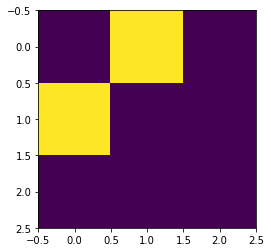

tensor([[0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


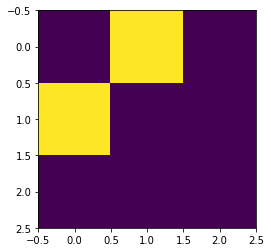

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward>)


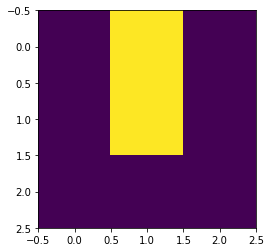

tensor([[1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


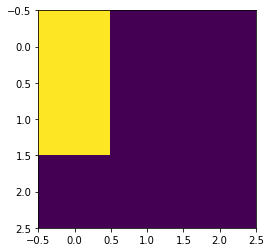

In [36]:
draw_mask(enc_attn, batch=1, stop=4)

In [37]:
t

tensor([[1, 0, 0, 0],
        [5, 7, 9, 2],
        [3, 7, 0, 0],
        [2, 9, 4, 0]])

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<SelectBackward>)


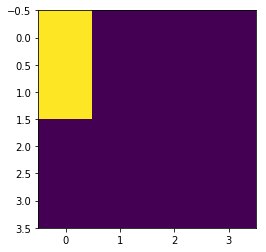

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<SelectBackward>)


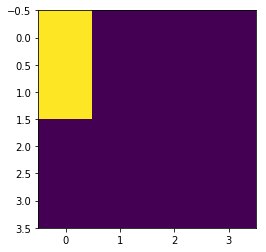

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


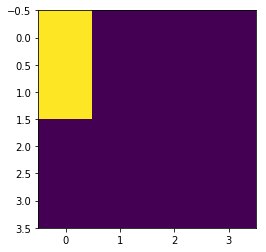

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<SelectBackward>)


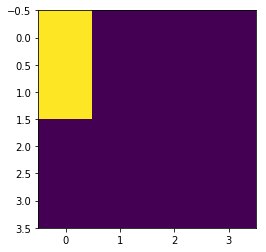

In [38]:
draw_mask(dec_self_attn, batch=2, stop=4)

tensor([[0.3781, 0.3450, 0.2769],
        [0.3340, 0.4613, 0.2047],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


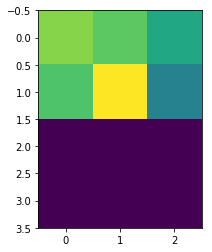

tensor([[0.6594, 0.2007, 0.1399],
        [0.3593, 0.4861, 0.1546],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


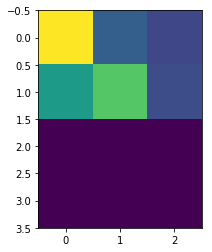

tensor([[0.1682, 0.5437, 0.2881],
        [0.1661, 0.3735, 0.4604],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


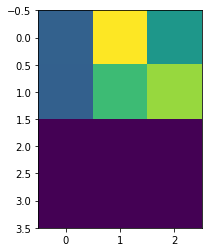

tensor([[0.0825, 0.4967, 0.4208],
        [0.5540, 0.2102, 0.2357],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward>)


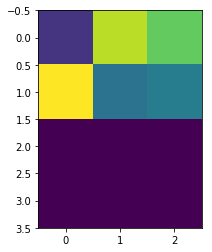

In [39]:
draw_mask(dec_enc_attn, batch=2, stop=4)

## Models: Encoder & Decoder - Transformer

In [40]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, max_seq_len, n_layer, n_head, d_model, d_k, d_v, d_f, 
                 drop_rate=0.1, use_conv=False, return_attn=True, pad_idx=0):
        super(Encoder, self).__init__()
        self.pad_idx = pad_idx
        self.return_attn = return_attn
        self.dropout = nn.Dropout(drop_rate)
        self.embed_layer = Embedding(vocab_len, d_model, pad_idx=pad_idx)
        self.pos_layer = PositionalEncoding(max_seq_len+1, d_model, pad_idx=0)
        self.layers = nn.ModuleList([Encode_Layer(n_head, d_model, d_k, d_v, d_f, 
                                                  drop_rate=drop_rate, 
                                                  use_conv=use_conv,
                                                  return_attn=return_attn) \
                                     for i in range(n_layer)])
        
    def forward(self, enc, enc_pos):
        """
        Inputs:
        * enc: (B, T)
        * enc_pos: (B, T)
        -------------------------------------
        Outputs:
        * enc_output: (B, T, d_model)
        * self_attns: (n_head*B, T, T)
        """
        self_attns = []  # (n_layer, n_head*B, T, T)
        # self attention padding mask: (B, T, T)
        attn_mask = get_padding_mask(q=enc, k=enc, pad_idx=self.pad_idx, mode='attn')
        non_pad_mask = get_padding_mask(q=enc, pad_idx=self.pad_idx, mode='nonpad')
        # embedding + position encoding: (B, T) --> (B, T, d_model)
        enc_output = self.embed_layer(enc) + self.pos_layer(enc_pos)
        enc_output = self.dropout(enc_output)
        # forward encode layer
        for enc_layer in self.layers:
            if self.return_attn:
                enc_output, enc_self_attn = enc_layer(enc_input=enc_output, 
                                                      enc_mask=attn_mask, 
                                                      non_pad_mask=non_pad_mask)
                self_attns.append(enc_self_attn)
            else:
                enc_output = enc_layer(enc_input=enc_output, 
                                       enc_mask=attn_mask, 
                                       non_pad_mask=non_pad_mask)
        
        if self.return_attn:
            return enc_output, self_attns
        return enc_output

In [41]:
class Decoder(nn.Module):
    def __init__(self, vocab_len, max_seq_len, n_layer, n_head, d_model, d_k, d_v, d_f, 
                 pad_idx=0, drop_rate=0.1, use_conv=False, return_attn=True):
        super(Decoder, self).__init__()
        self.pad_idx = pad_idx
        self.return_attn = return_attn
        self.dropout = nn.Dropout(drop_rate)
        self.embed_layer = Embedding(vocab_len, d_model, pad_idx=pad_idx)
        self.pos_layer = PositionalEncoding(max_seq_len+1, d_model, pad_idx=0)
        self.layers = nn.ModuleList([Decode_Layer(n_head, d_model, d_k, d_v, d_f, 
                                                  drop_rate=drop_rate, 
                                                  use_conv=use_conv,
                                                  return_attn=return_attn) \
                                     for i in range(n_layer)])
        
    def forward(self, dec, dec_pos, enc, enc_output):
        """
        Inputs:
        * dec: (B, T_q)
        * dec_pos: (B, T_q)
        * enc: (B, T)
        * enc_output: (B, T, d_model)
        -------------------------------------
        Outputs:
        * dec_output: (B, T_q, d_model)
        * self_attns: (n_head*B, T_q, T_q)
        * dec_enc_attns: (n_haed*B, T_q, T)
        """
        self_attns = []  # (n_layer, n_head*B, T_q, T_q)
        dec_enc_attns = []  # (n_layer, n_head*B, T_q, T)
        
        # self attention padding mask: (B, T_q, T)
        non_pad_mask = get_padding_mask(q=dec, pad_idx=self.pad_idx, mode='nonpad')
        attn_mask = get_padding_mask(q=dec, k=dec, pad_idx=self.pad_idx, mode='attn')
        subseq_mask = get_padding_mask(q=dec, mode='subseq')
        self_attn_mask = (attn_mask + subseq_mask).gt(0)
        # enc_dec attention padding mask
        dec_enc_attn_mask = get_padding_mask(q=dec, k=enc, pad_idx=self.pad_idx, mode='attn')
        
        # embedding + position encoding: (B, T) --> (B, T, d_model)
        dec_output = self.embed_layer(dec) + self.pos_layer(dec_pos)
        dec_output = self.dropout(dec_output)
        # forward decode layer
        for dec_layer in self.layers:
            if self.return_attn:
                dec_output, dec_self_attn, dec_enc_attn = dec_layer(dec_input=dec_output, 
                                                                    enc_output=enc_output, 
                                                                    dec_self_mask=self_attn_mask, 
                                                                    dec_enc_mask=dec_enc_attn_mask,
                                                                    non_pad_mask=non_pad_mask)
                self_attns.append(dec_self_attn)
                dec_enc_attns.append(dec_enc_attn)
            else:
                dec_output = dec_layer(dec_input=dec_output, 
                                       enc_output=enc_output, 
                                       dec_self_mask=self_attn_mask, 
                                       dec_enc_mask=dec_enc_attn_mask,
                                       non_pad_mask=non_pad_mask)
        
        if self.return_attn:
            return dec_output, self_attns, dec_enc_attns
        return dec_output

In [42]:
n_layer = 3
encoder = Encoder(vocab_len, 3, n_layer, n_head, d_model, d_k, d_v, d_f)
decoder = Decoder(vocab_len, 4, n_layer, n_head, d_model, d_k, d_v, d_f)

In [43]:
enc_output, enc_self_attns = encoder(x, po_x)
dec_output, dec_self_attns, dec_enc_attns = decoder.forward(t, po_t, x, enc_output)

In [44]:
enc_output.size(), dec_output.size()

(torch.Size([4, 3, 256]), torch.Size([4, 4, 256]))

In [45]:
class Transformer(nn.Module):
    def __init__(self, enc_vocab_len, enc_max_seq_len, dec_vocab_len, dec_max_seq_len, 
                 n_layer, n_head, d_model, d_k, d_v, d_f, 
                 pad_idx=0, drop_rate=0.1, use_conv=False, return_attn=True,
                 linear_weight_share=True, embed_weight_share=True):
        super(Transformer, self).__init__()
        self.return_attn = return_attn
        self.pad_idx = pad_idx
        self.d_model = d_model
        
        self.encoder = Encoder(enc_vocab_len, enc_max_seq_len, n_layer, n_head, 
                               d_model, d_k, d_v, d_f, 
                               pad_idx=pad_idx, 
                               drop_rate=drop_rate, 
                               use_conv=use_conv, 
                               return_attn=return_attn)
        self.decoder = Decoder(dec_vocab_len, dec_max_seq_len, n_layer, n_head, 
                               d_model, d_k, d_v, d_f,
                               pad_idx=pad_idx, 
                               drop_rate=drop_rate, 
                               use_conv=use_conv, 
                               return_attn=return_attn)
        self.projection = XavierLinear(d_model, dec_vocab_len, bias=False)
        if linear_weight_share:
            # share the same weight matrix between the decoder embedding layer 
            # and the pre-softmax linear transformation
            self.projection.linear.weight = self.decoder.embed_layer.embedding.weight
        
        if embed_weight_share:
            # share the same weight matrix between the decoder embedding layer 
            # and the encoder embedding layer
            assert enc_vocab_len == dec_vocab_len, "vocab length must be same"
            self.encoder.embed_layer.embedding.weight = self.decoder.embed_layer.embedding.weight
            
    def forward(self, enc, enc_pos, dec, dec_pos):
        """
        Inputs:
        * enc: (B, T)
        * enc_pos: (B, T)
        * dec: (B, T_q)
        * dec_pos: (B, T_q)
        -------------------------------------
        Outputs:
        * dec_output: (B*T_q, d_model)
        * attns_dict:
            * enc_self_attns: (n_head*B, T, T)
            * dec_self_attns: (n_head*B, T_q, T_q)
            * dec_enc_attns: (n_haed*B, T_q, T)
        """
        if self.return_attn:
            enc_output, enc_self_attns = self.encoder(enc, enc_pos)
            dec_output, dec_self_attns, dec_enc_attns = self.decoder(dec, dec_pos, enc, enc_output)
            dec_output = self.projection(dec_output)
            attns_dict = {'enc_self_attns': enc_self_attns, 
                         'dec_self_attns': dec_self_attns,
                         'dec_enc_attns': dec_enc_attns}
            return dec_output.view(-1, dec_output.size(2)), attns_dict
        else:
            enc_output = self.encoder(enc, enc_pos)
            dec_output = self.decoder(dec, dec_pos, enc, enc_output)
            dec_output = self.projection(dec_output)
            return dec_output.view(-1, dec_output.size(2))

In [46]:
model = Transformer(vocab_len, 3, vocab_len, 4, n_layer, n_head, d_model, d_k, d_v, d_f, 
                 pad_idx=0, drop_rate=0.1, use_conv=False, return_attn=False,
                 linear_weight_share=True, embed_weight_share=False)

In [47]:
output = model(x, po_x, t, po_t)

In [48]:
output.size()

torch.Size([16, 10])

## Label Smoothing

* Ref: https://arxiv.org/pdf/1512.00567.pdf

cross-entropy: $l = - \sum_{k=1}^{K} \log(p(k))q(k)$

$\dfrac{\partial l}{\partial z_{k}} = p(k) - q(k)$ where $q(k) = \delta_{k, y}$

$q(k)$ is not achivable, where $z_y \gg z_k$ where $k \neq y$

Only using cross-entropy loss cause two problems. First, it may result in over-fitting: if the model learns to assign full probability to the groundtruth label for each training example, it is not guaranteed to generalize. Second, it encourages the differences between the largest logit and all others to become large, and this, combined with the bounded gradient $\frac{\partial l}{\partial z_{k}}$, reduces the ability of the model to adapt. Intuitively, this happens because the model becomes too confident about its predictions

### proposed method: label-smoothing regularization

* $u(k)$: a distribution over labels, independent of the training example $x$
* $\epsilon$: a smoothing parameter

For a training example with ground-truth label $y$, replace the label distribution $q(k) = \delta_{k, y}$ to

$$q'(k \vert x) = (1-\epsilon)\delta_{k, y}+\epsilon u(k)$$

This can be seen as the distribution of the label $k$ obtained as follows: first, set it to the groundtruth label $k = y$; then, with probability $\epsilon$, replace $k$ with a sample drawn from the distribution $u(k)$. We propose to use the prior distribution over labels as $u(k)$. In our experiments, we used the uniform distribution $u(k) = 1/K$, so that

$$q'(k \vert x) = (1-\epsilon)\delta_{k, y}+ \dfrac{\epsilon}{K}$$

Another interpretation: $q'$ is changed true probability.

$$\begin{aligned} H(q', p) &= -\sum_{k=1}^K q'(k) \log p(k)  \\
&= -\sum_{k=1}^K \big( ((1-\epsilon)q(x) + \epsilon u(x)) \log p(k) \big) \\
&= -\sum_{k=1}^K (1-\epsilon)q(x) \log p(k) + -\sum_{k=1}^K \epsilon u(x) \log p(k) \\
&= (1-\epsilon) H(q, p) + \epsilon H(u, p) \end{aligned}$$

this can be seen as $H(q', p) = H(q, p) + \dfrac{\epsilon}{(1-\epsilon) } \big( D_{KL}(u \vert\vert p) + H(u) \big) $ and $H(u)$ is fixed. When $u$ is the uniform distribution, $H(u, p)$ is a measure of how dissimilar the predicted distribution $p$ is to uniform, which could also be measured (but not equivalently) by negative entropy $−H(p)$;



In [77]:
class LabelSmoothing(nn.Module):
    """Label Smoothing"""
    def __init__(self, trg_vocab_size, pad_idx, eps=0.0):
        super(LabelSmoothing, self).__init__()
#         self.criterion = nn.KLDivLoss(reduction='sum')
        self.criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
        self.pad_idx = pad_idx
        self.eps = eps
        self.trg_vocab_size = trg_vocab_size
        self.true_dist = None
        
    def forward(self, x, target):
        """
        Inputs:
        x: (B, T_q, V_target), scores
        t: (B, T_q)
        ref: https://arxiv.org/pdf/1512.00567.pdf  
        #7
        q'(k | x) = (1 - eps) q(k) + eps * u(k)
        where: q(k) = 1 if k == 'target class' else 0
        """
        
        assert x.size(1) == self.trg_vocab_size, \
            'vocab size is not equal x: {}, vocab: {}'.format(x.size(1), self.trg_vocab_size)
        assert target.dim() == 2, 't must be size of (B, T_q)'
        if self.eps == 0.0:
            x = x.view(-1, x.size(2))
            return self.criterion(x, target.view(-1))
        
        true_dist = torch.zeros_like(x)
        true_dist = true_dist.scatter(1, target.view(-1, 1), 1.0)
        true_dist = (1 - self.eps) * true_dist + self.eps / (self.trg_vocab_size -1)
        log_prob = F.log_softmax(x, dim=1)
        loss = -(true_dist * log_prob).sum(1)
        non_pad_mask = target.view(-1).ne(self.pad_idx)
        self.true_dist = true_dist
        loss = loss.masked_select(non_pad_mask).sum()
        return loss
        
#         true_dist = x.clone()
#         # u(k) = 1 / K, exclude token <s>, <pad>
#         true_dist.fill_(self.eps / (self.trg_vocab_size - 2))  
#         # at target index, value is (1-eps) * 1
#         true_dist.scatter_(1, target.view(-1, 1), self.confidence)
#         true_dist[:, self.pad_idx] = 0  # exclude token <s>
#         mask = torch.nonzero(target.view(-1) == self.pad_idx)
#         if mask.dim() > 0:
#             true_dist.index_fill_(0, mask.squeeze(), 0.0)
#         self.true_dist = true_dist
#         return self.criterion(x.log_softmax(1), true_dist.detach())

In [78]:
lbs = LabelSmoothing(10, 0, eps=0.1)

In [79]:
lbs(output, t)

tensor(65.3785, grad_fn=<SumBackward0>)

In [52]:
# one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
# one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
# log_prb = F.log_softmax(pred, dim=1)

# non_pad_mask = gold.ne(Constants.PAD)
# loss = -(one_hot * log_prb).sum(dim=1)
# loss = loss.masked_select(non_pad_mask).sum()  # average later